In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytransit import QuadraticModel
from decimal import Decimal
import emcee
import corner
from IPython.display import display, Math
import csv 
from numpy import savetxt
from numpy import loadtxt
from numpy import random
from multiprocessing import Pool
from transitleastsquares import transitleastsquares
import batman
import statistics
from statistics import mode
import pandas as pd
from tabulate import tabulate
from stochastic.processes.base import BaseTimeProcess
from stochastic.utils.validation import check_numeric
from stochastic.utils.validation import check_positive_integer
from stochastic.processes.noise import ColoredNoise
from stochastic.processes.noise import GaussianNoise

import seaborn as sns

In [ ]:
input_periods_array = np.array([])
periods_array = np.array([])
rp_over_rstar_range = np.array([])
detection_array = np.array([])
periods_array = np.array([])
FAP_array = np.array([])
periods_for_heatmap = np.array([])
ronr_for_heatmap = np.array([])
detection_for_heatmap = np.array([])
    
    
def find_period(period, rp_over_rstar):
    
    global periods_array, rand_phases, detection_array, FAP_array
    
    #Enter parameters
    period = period
    rp_over_rstar = rp_over_rstar
    a_over_rstar = 19.53338
    inc = 90.
    error_amount = 10 ** (-3) #per point error this s the transit depth of the earth around the star

    params = [period, rp_over_rstar, a_over_rstar, inc]

#     #gaussian noise array
#     flux_err = np.array([])
#     for timestep in range(1,19441):
#         noise = random.normal(0,error_amount)
#         flux_err = np.append(flux_err, noise)

    #Make colored Noise
    colored_noise = ColoredNoise(beta=1,t=27, rng=None) #t is right hand endpoint, -1=blue 2=red 1=pink -2=violet 0=white


    cmag = error_amount /.007 #i believe the error is automatically at .007 compared to my error function, just from eyeballing
    cnoise = colored_noise.sample(19439)
    flux_err = cnoise * cmag

    #time array
    time = np.linspace(0,27,19441)


     #Batman
    from matplotlib import rcParams; rcParams["figure.dpi"] = 150

    # Create test data
    time_start = 0 # time to start first transit
    data_duration = 27
    samples_per_day = 720
    samples = int(data_duration * samples_per_day)
    time = np.linspace(0, data_duration, samples)

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period
    ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
    ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
    ma.inc = inc  # orbital inclination (in degrees)
    ma.ecc = 0.  # eccentricity
    ma.w = 0.  # longitude of periastron (in degrees)
    ma.u = [0.0, 0.0]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Create noise and merge with flux

    flux = synthetic_signal + flux_err

    # Plot Batman flux array (points)
    plt.figure()
    ax = plt.gca()
    ax.scatter(time, flux, color='black', s=1)
    plt.title('Simulated lightcurve (Correlated Noise)')
    ax.set_ylabel("Flux")
    ax.set_xlabel("Time (days)")

    plt.plot(time, flux)

    # Running transit least squares
    leastsquares = transitleastsquares(time, flux)#binned:(time_bin, flux_bin) #unbinned: (time, lc_w_noise)
    results = leastsquares.power()


    # Showing the batman plot

    plt.figure()
    ax = plt.gca()
    ax.axvline(results.period, alpha=0.4, lw=3)
    plt.xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel(r'SDE')
    plt.xlabel('Period (days)')
    plt.plot(results.periods, results.power, color='black', lw=0.5)
    plt.xlim(0, max(results.periods))

    periods_array = np.append(periods_array, results.period)
    FAP_array = np.append(FAP_array,results.FAP) #if greater than 10^(-4)

    if results.FAP < .0001 and period *.99 < results.period < period* 1.01:
        detection_array = np.append(detection_array, 1)
    else:
        detection_array = np.append(detection_array, 0)

#generate n periods
period = 0
for x in range(0,1):
    period = period + 5
    input_periods_array = np.append(input_periods_array, period)
print(input_periods_array)
    
#generate n rp_over_rstars
rp_over_rstar = .015    
for x in range(0,1):
    rp_over_rstar = rp_over_rstar + .0005
    rp_over_rstar_range = np.append(rp_over_rstar_range, rp_over_rstar)
print(rp_over_rstar_range)
    
#run TLS n times for each pair 
for x in input_periods_array:
    for y in rp_over_rstar_range:
        for each in range (0,1):
            find_period(x, y)
        periods_for_heatmap = np.append(periods_for_heatmap, x)
        ronr_for_heatmap = np.append(ronr_for_heatmap, y)
        detection_percent = sum(detection_array) / 10
        detection_for_heatmap = np.append(detection_for_heatmap, detection_percent)
        print(detection_array)
        detection_array = ([])

        
        
print(periods_for_heatmap)
print(ronr_for_heatmap)
print(detection_for_heatmap)
#print(FAP_array)


In [30]:
print(periods_array)


[12.63766693  4.99721555  4.99721555  4.99721555  4.99721555  4.99721555
  5.00520006  4.99721555  4.99721555  4.99721555  4.99721555  4.99721555
  4.99721555  4.99721555  4.99721555  4.99721555  4.99721555  4.99721555
  4.99721555  4.99721555  9.99928056  9.99928056 11.8226451   6.68795608
  9.99928056  9.99928056  9.99928056 13.3799834   9.99928056  9.99928056
  9.99928056  9.99928056  9.99928056  9.99928056 10.80416786  7.88370718
  9.99928056  9.99928056 13.49930552  9.38237603]


periods: [ 5.  5. 10. 10.]
ronr: [0.0155 0.016  0.0155 0.016 ]
percent found: [0.9 1.  0.3 0.4]


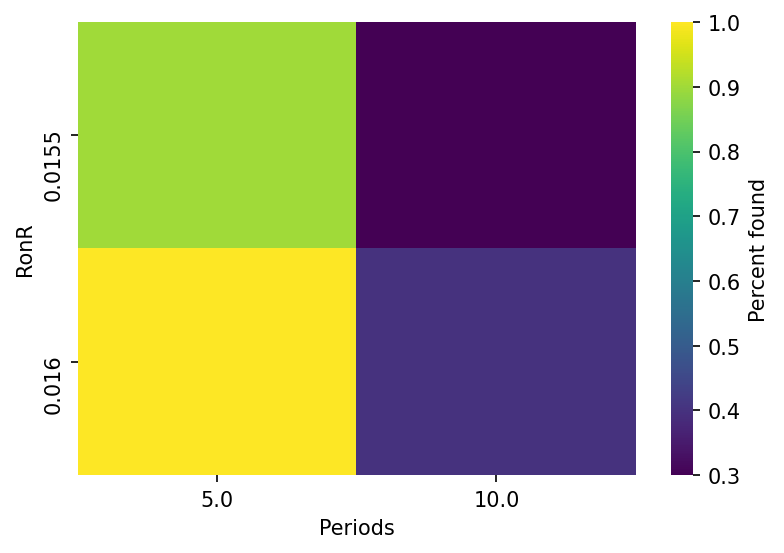

In [31]:
print("periods:" , periods_for_heatmap)
print("ronr:" , ronr_for_heatmap)
print("percent found:" , detection_for_heatmap)
#print(FAP_array)

data = pd.DataFrame({'RonR': ronr_for_heatmap, 'Periods': periods_for_heatmap, 'Detection': detection_for_heatmap})
data_pivoted = data.pivot("RonR", "Periods", "Detection")
data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")
#pd.plot(kind='RonR',rot=0)

#plt.title()
data_pivoted.collections[0].colorbar.set_label("Percent found")
plt.show()